In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#%matplotlib notebook

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit_aer
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector

# Quantum Fourier Transform <br /> and Quantum Phase Estimation

## A short tutorial



# Overview

* QFT: *discrete* Fourier transform on wavefunction amplitudes
* Exponentially faster than the best known classical algorithms
    * But does not speed up FT of classical data
    * Remember, QCs operate in superposition, not "classically parallel". Measurement will collapse the superposition and we only obtain one projected value.
    * But within a cleverly constructed algorithm, QFT becomes a crucial subroutine
* Critical subproblem in **phase estimation**
    * Estimate the phase of a unitary operator to arbitrary precision
    * Shor's algorithm (factoring)
    * Solve linear systems of equations
    * Ground state energy of Hamiltonian
    * More?

# Fourier Transform Background

It's useful to start by revisiting the FT and the discrete FT (DFT), since the QFT is a DFT performed on qubit amplitudes with quantum gates. Here we make use of plotting tools in python to emphasize the geometric intuition in complex space behind Fourier transforms.

## Fourier Transforms and Conjugate Variables

As a reminder, the (typically defined) Fourier transform takes a time-domain signal and transforms it into frequency space.

$$ \tilde{X}(f) = \int_{-\infty}^\infty x(t)~e^{-i f t 2\pi}~dt$$

This also works on any pair of conjugate variables. Of course, the ones we are most familiar with are position-momentum!

$$ \phi(p) = \frac{1}{\sqrt{2\pi h}} \int_{-\infty}^\infty \psi(x)~e^{-i p x / \hbar}~dx$$

In the QFT case, our conjugate variables are the abstract "computational basis" and "Fourier basis". But we can use these variables to represent other conjugate variables by using an appropriate encoding. For example, Shor's algorithm maps our qubits into a problem about periods (and thus frequency), while Hamiltonian simulation maps our qubits onto the familiar position and momentum.

*Note: There are different choices of variables and normalization for the FT, which is why different factors show up above. However, the fundamental transform is unchanged.*

We can use the numpy library to play around with numeric calculations. In most introductory presentations, we're used to thinking about the (real) Fourier transform with $sin$ and $cos$. In this presentation, however, we emphasize the complex Fourier transform, since we are dealing with wavefunctions.

We present 3D representations of the complex exponential, which hopefully provide a bit of geometric intuition and sheds some light on the underlying connection.

As we know, the FT of a free-particle wavefunction should give a precisely defined momentum, so let's try to demonstrate that!

Let's plot $x = e^{2\pi i (tf)}$

Text(0.5, 0, 'x_imag')

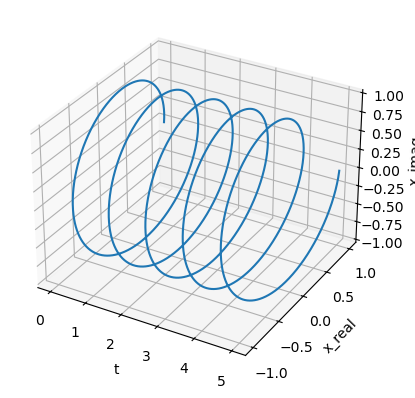

In [13]:
sampFreq = 1e3

f = 1  # Wave frequency (feel free to change!)
t = np.arange(0, 5, 1/sampFreq)
x = np.exp(1j*2*np.pi*t*f)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t, x.real, x.imag)
ax.set_xlabel("t")
ax.set_ylabel("x_real")
ax.set_zlabel("x_imag")

(0.0, 10.0)

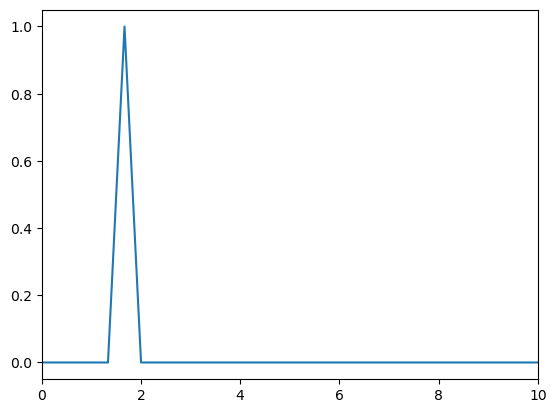

In [15]:
xF = np.fft.fft(x) / len(x) # FFT and normalize
xF = xF[range(int(len(x)/2))] # Remove sampling frequency

# Convert x-axis values
num = len(x)
values = np.arange(int(num/2))
timePeriod  = num/sampFreq
frequencies = values/3

fig, ax = plt.subplots()
ax.plot(frequencies, abs(xF))
ax.set_xlim(0, 10)

An arbitrary wavefunction can be decomposed into the basis of free-particle wavefunctions, and the Fourier transform will extract out their precisely defined momentums.

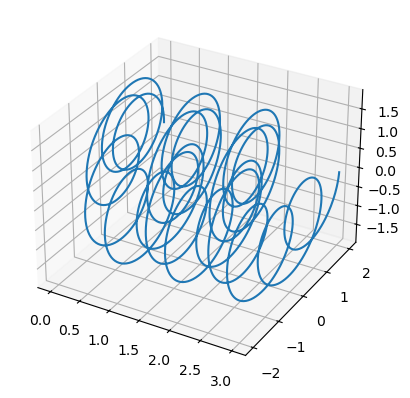

In [17]:
sampFreq = 1e3

f1 = 1 # First wave frequency (feel free to change)
f2 = 7 # Second wave frequency (feel free to change)
t = np.arange(0, 3, 1/sampFreq)
x = np.exp(1j*2*np.pi*t*f1) + np.exp(1j*2*np.pi*t*f2)
   
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t, x.real, x.imag)

(0.0, 10.0)

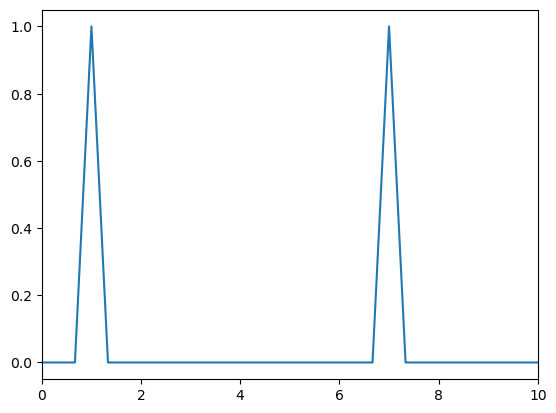

In [19]:
xF = np.fft.fft(x) / len(x) # FFT and normalize
xF = xF[range(int(len(x)/2))] # Remove sampling frequency

# Convert x-axis values 
num = len(x)
values = np.arange(int(num/2))
timePeriod  = num/sampFreq
frequencies = values/3

fig, ax = plt.subplots()
ax.plot(frequencies, abs(xF))
ax.set_xlim(0, 10)

The *discrete* FT is very similar, but acts on vectors instead. This can be thought of as similar to taking N samples from the continuous case. Of course, sampling does introduce some subtle differences (c.f. aliasing and the Nyquist-Shannon theorem), but it's not necessary to go into the details here. The interested reader is directed to a nice tutorial: https://jackschaedler.github.io/circles-sines-signals/index.html.

$$ \text{Continuous:}\quad\tilde{X}(f) = \int_{-\infty}^\infty x(t)~e^{-i f t 2\pi}~dt$$

$$ \text{Discrete:}\quad\tilde{X}(f) = \sum_{f=0}^{N-1} x[t]~e^{-i f t \frac{2\pi}{N}}$$

$$\text{where $x[t]$ is a vector of $N$ values:}\quad[x_0, x_1, x_2, ..., x_{N-1}]$$

The Quantum Fourier Transform is the implementation of the DFT on a quantum computer. Remember, the
computational wavefunction lives in a finite-dimensional Hilbert space ($N=2^n$ for $n$ qubits).

### Quick Example

Let's use an example that's much closer to what will be encountered in the QFT circuit later on. Say we have a 3-qubit state. Each of these qubits has two states, so in total we have a $2^3 = 8$ state space. If we label the states with integers from 0 to 7, we can construct a mapping between the "qubit" representation and the "integer" representation by treating the qubits as a binary number. For example, $|001\rangle$ becomes 1, and $|100\rangle$ becomes 4.

Although this mapping is in some sense an arbitrary choice, it allows us to make a conceptual mapping between the classical DFT and the QFT operation being done on the quantum circuit. The DFT (and hence the QFT) should give us plane waves rotating at various frequencies (see last section for more details), but we take discrete samples from it.

<StemContainer object of 3 artists>

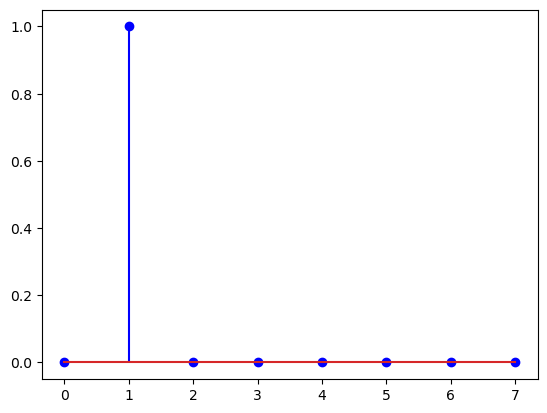

In [15]:
x = [0, 1, 0, 0, 0, 0, 0, 0] # Impulse at 1

fig, ax = plt.subplots()
ax.stem(x,linefmt='b-', markerfmt='bo')

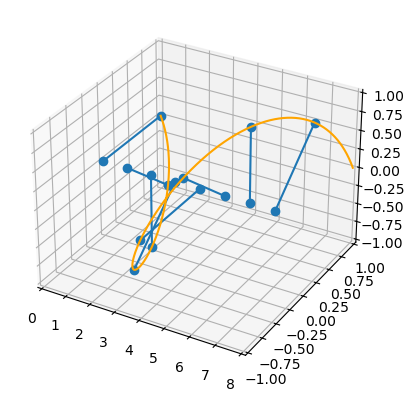

In [17]:
xF = np.fft.fft(x)

t = np.arange(0, 1, 1/sampFreq)
env = np.exp(-1j*2*np.pi*t)

fig = plt.figure()
ax = plt.axes(projection='3d')
for ti, xi, yi in zip(range(len(x)), xF.real, xF.imag):        
    line=art3d.Line3D(*zip((ti, 0, 0), (ti, xi, yi)), marker='o')
    ax.add_line(line)
ax.set_xlim3d(0, len(x)) 
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.plot3D(t*8, env.real, env.imag, c="orange") # Plot is interactive, please drag around to rotate

If we take the delta function at 2 (i.e. $|010\rangle$), then the plane wave rotates twice as fast:

<StemContainer object of 3 artists>

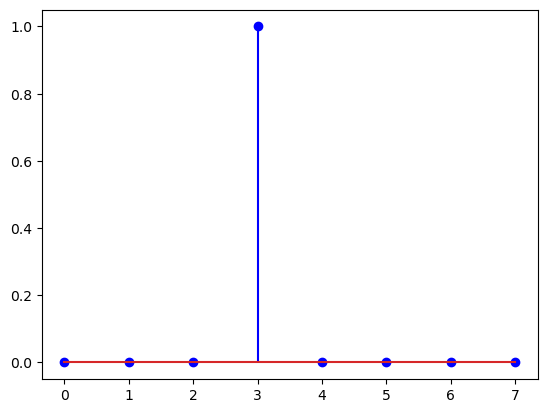

In [19]:
x = [0, 0, 0, 1, 0, 0, 0, 0] # Impulse at 2

fig, ax = plt.subplots()
ax.stem(x, linefmt='b-', markerfmt='bo')

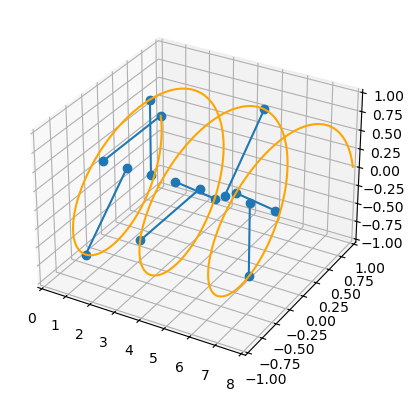

In [21]:
xF = np.fft.fft(x)

t = np.arange(0, 1, 1/sampFreq)
env = np.exp(-1j*3*2*np.pi*t)

fig = plt.figure()
ax = plt.axes(projection='3d')
for ti, xi, yi in zip(range(len(x)), xF.real, xF.imag):        
    line=art3d.Line3D(*zip((ti, 0, 0), (ti, xi, yi)), marker='o')
    ax.add_line(line)
ax.set_xlim3d(0, len(x)) 
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.plot3D(t*8, env.real, env.imag, c="orange")

In [35]:
%matplotlib inline
# Brings the MPL backend back to non-interactive mode

# A note before we get into the QFT
In our code, we want to draw parallels to the binary representations in the computational basis. If you've seen the QFT before, you might think that we have everything "perfectly swapped". We do this to make sure that the 0th qubit spins the slowest.

## Quantum Fourier Transform

The QFT is the DFT applied to the amplitudes of the statevector. As before, we can think of this as similar to taking a wavefunction from position to momentum space:

$$ \phi(p) = \frac{1}{\sqrt{2\pi h}} \int_{-\infty}^\infty \psi(x)~e^{-i p x / \hbar}~dx$$

But because we're in the finite-dimensional $2^N$ qubit space, we are working with the discrete transform. We also change our normalization and variable conventions slightly. The Fourier transform is defined to be:

$$ |q\rangle \rightarrow \frac{1}{\sqrt{N}}\sum_{p=0}^{N-1}e^{\frac{2\pi}{N} i q p} |p\rangle $$

Strictly speaking, this takes us from the "computational basis" to a "Fourier basis". However, the actual meaning of these states will depend on the algorithm. For example, Shor's algorithm maps our qubits into a problem about periods (and thus frequency), while Hamiltonian simulation maps our qubits onto the familiar position and momentum.

As hinted at in some previous slides, a qubit state, which is normally written as the tensor product of 2-level states, can also be thought of as living in a $2^N$-level state.

## 1 Qubit
Let's take a look at the single-qubit case and build to the general case.

$$ \begin{aligned}
|q\rangle &\rightarrow \frac{1}{\sqrt{N}}\sum_{p=0}^{N-1}e^{\frac{2\pi}{N} i q p} |p\rangle \\
&\rightarrow |0\rangle + e^{i\pi q} |1\rangle
\end{aligned} $$

If we consider the action of the QFT on the computational basis states $|0\rangle$ and $1\rangle$:

$$\begin{aligned}
|0\rangle &\rightarrow |0\rangle + e^{i\pi 0} |1\rangle &\rightarrow |0\rangle + |1\rangle \\
|1\rangle &\rightarrow |0\rangle + e^{i\pi 1} |1\rangle &\rightarrow |0\rangle - |1\rangle \\
\end{aligned}$$

So the 1-qubit QFT is just a Hadamard gate!

## 2 Qubits

How about the 2-qubit case?

$$ \begin{aligned}
|q\rangle &\rightarrow \frac{1}{\sqrt{N}}\sum_{p=0}^{N-1}e^{\frac{2\pi}{N} i q } |p\rangle \\
&\rightarrow \frac{|0\rangle + e^{i\frac{\pi}{2} q} |1\rangle + e^{i\frac{2\pi}{2} q} |2\rangle + e^{i\frac{3\pi}{2} q } |3\rangle}{2} \\
&\rightarrow \frac{|00\rangle + e^{i\frac{\pi}{2} q} |01\rangle + e^{i\frac{2\pi}{2} q} |10\rangle + e^{i\frac{3\pi}{2} q } |11\rangle}{2}
\end{aligned} $$

It might be confusing looking at the combined phase factor. Let's take a closer look at the phase factor decomposed into individual qubits. 

Remember, $q$ is a *discrete* value, and we can always represent an arbitrary state as a superposition of $|q\rangle$ states. So we can expand the $q$ in each phase into the individual qubits as $q = 2 q_0+ q_1$:

$$ \begin{aligned}
|q_0q_1\rangle &\rightarrow  \frac{|00\rangle + e^{i\frac{\pi}{2} (2q_0+ q_1)} |01\rangle + e^{i\frac{2\pi}{2} (2q_0+ q_1)} |10\rangle + e^{i\frac{3\pi}{2} (2q_0+ q_1)} |11\rangle}{2} \\
&\rightarrow \frac{\left(|0\rangle + e^{i 2\pi \left(q_0 + \frac{q_1}{2}\right)} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{q_0}{2} + \frac{q_1}{4}\right)} |1\rangle \right)}{2} \\
&\rightarrow \frac{\left(|0\rangle + e^{i 2\pi \frac{q_1}{2}} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{q_0}{2} + \frac{q_1}{4}\right)} |1\rangle \right)}{2}
\end{aligned} $$

where the $e^{i 2\pi p_1}$ can be removed, since $p_1$ can only be a 0 or a 1. This is a product state, so we see that each output qubit of the QFT is the $|+\rangle$ state with some additional phase rotation, depending on whether or not the respective qubits of the input qubits are $|1\rangle$.

If we actually plug in these numbers, we get

$$\begin{aligned}
\text{Computational}&\rightarrow \text{Fourier} \\
|00\rangle &\rightarrow (|0\rangle+|1\rangle) \otimes (|0\rangle+|1\rangle) \\
|01 \rangle &\rightarrow (|0\rangle+e^{i\pi}|1\rangle) \otimes (|0\rangle+e^{i\pi/2}|1\rangle) \\
|10 \rangle &\rightarrow (|0\rangle+|1\rangle) \otimes (|0\rangle+ e^{2i\pi/2}|1\rangle) \\
|11 \rangle &\rightarrow (|0\rangle+e^{i\pi}|1\rangle) \otimes (|0\rangle+ e^{3i\pi/2}|1\rangle) 
\end{aligned}$$

If you're perplexed by the swap, try working out the 2-qubit case circuit given below! We want the 0th qubit to spin the fastest, but the formula has an rotation that is dependent on $q_1$. 

In [4]:
from qiskit import QuantumCircuit

## Fourier Transform Definition

$$ |q\rangle \rightarrow \frac{1}{\sqrt{N}}\sum_{p=0}^{N-1}e^{\frac{2\pi}{N} i q p} |p\rangle $$

where $N=2^\mathrm{n}$ is the number of states, and $n$ is the number of qubits.


## Gate Representation

### 1-Qubit

Dropping $(1/\sqrt{2})$ for convenience,
$$ |q_0\rangle \rightarrow |0\rangle + e^{i\pi q_0} |1\rangle$$


$$\begin{aligned}
|0\rangle &\rightarrow |0\rangle + e^{i\pi 0} |1\rangle &\rightarrow |0\rangle + |1\rangle \\
|1\rangle &\rightarrow |0\rangle + e^{i\pi 1} |1\rangle &\rightarrow |0\rangle - |1\rangle \\
\end{aligned}$$

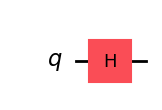

In [5]:
circ1 = QuantumCircuit(1)

circ1.h(0)

circ1.draw(output='mpl')

### 2-Qubit

$$|q_0q_1\rangle \rightarrow \frac{\overbrace{\left(|0\rangle + e^{i \pi q_1} |1\rangle \right)}^{q_0~\text{output}} \overbrace{\left(|0\rangle + e^{i \pi \left(q_0 + \frac{q_1}{2}\right)} |1\rangle \right)}^{q_1~\text{output}}}{2}$$

We need to apply Hadamards on both qubits to place them into $|0\rangle + |1\rangle$ superpositions. The $q_1$-Hadamard qubit then gets an additional quarter-rotation (S-gate) depending on the $q_0$ qubit.

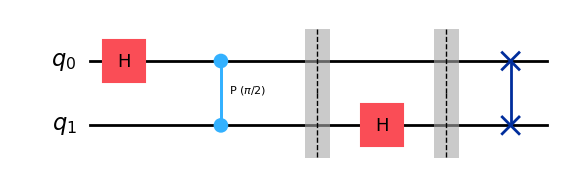

In [6]:
circ2 = QuantumCircuit(2)

circ2.h(0)
circ2.cp(np.pi/2, 1, 0)
circ2.barrier()

circ2.h(1)
circ2.barrier()

circ2.swap(0, 1)
circ2.draw(output='mpl')


Note: if you look carefully, you can see that the input order of the qubits is swapped! The left qubit of the output ($p_1$) is computed on the Hadamard of $q_0$. The right qubit of the output ($p_0$) is computed on the Hadamard of $q_1$ plus an additional controlled-S from $q_0$. Thus, we need to *reverse* the output at the end using swap gates.

Additionally, we perform the operations of the actual circuit from "right-to-left" of the output representation above to correctly enforce the dependent order. If we did it from "left-to-right", then $q0$ would have been Hadamard-ed before it was used in the controlled-S operation.

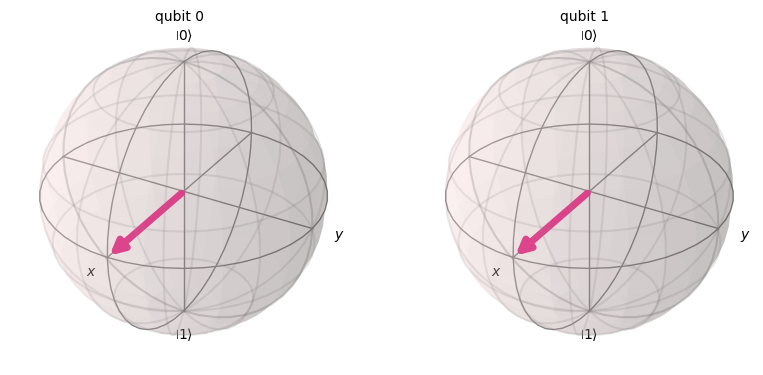

In [12]:
from qiskit import transpile
from qiskit.visualization import plot_bloch_multivector

prepend2 = QuantumCircuit(2)

# Comment the next or the following lines to prepare different input states

# Comment all out for |00>

# |01>
#prepend2.x(1)

# |10>
#prepend2.x(0)


# |11>
#prepend2.x(0)
#prepend2.x(1)

prepend2.barrier()

test2 = prepend2 & circ2
test2.draw(output='mpl')
statevector = Statevector(test2)
plot_bloch_multivector(statevector)

### 3 Qubits
Similarly, we can do the 3-qubit QFT:

$$|q_0 q_1 q_2\rangle = \frac{\left(|0\rangle + e^{i 2\pi \frac{q_2}{2}} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{q_1}{2} + \frac{q_2}{4}\right)} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{q_0}{2} + \frac{q_1}{4} + \frac{q_2}{8}\right)} |1\rangle \right)}{\sqrt{8}}$$

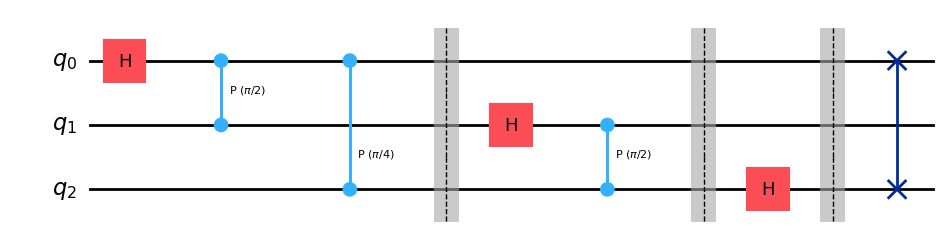

In [13]:
circ3 = QuantumCircuit(3)

circ3.h(0)
circ3.cp(pi/2,1,0)
circ3.cp(pi/4,2,0)
#circ3.cu(np.pi/2,0,0,0,1, 0)
#circ3.cu(np.pi/4,0,0,0,2, 0)
circ3.barrier()

circ3.h(1)
circ3.cp(pi/2,2,1)
#circ3.cu(np.pi/2,0,0,0,2, 1)
circ3.barrier()

circ3.h(2)
circ3.barrier()

circ3.swap(0, 2)

circ3.draw(output='mpl')

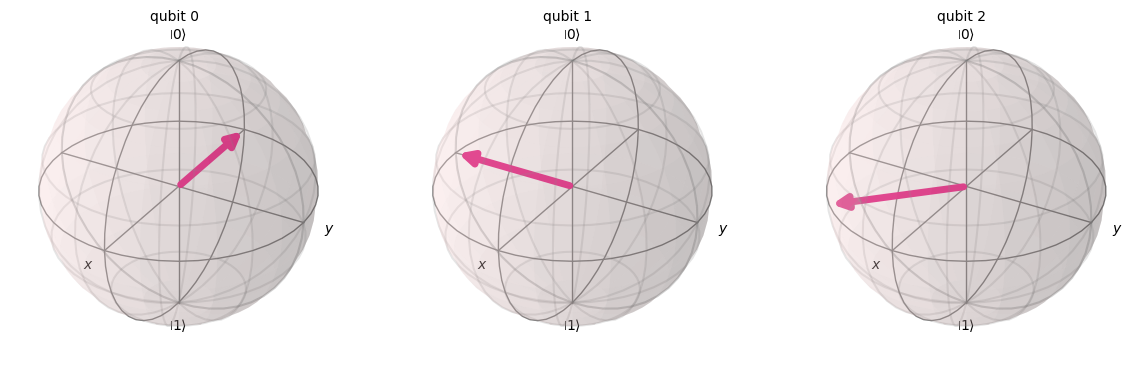

In [23]:
prepend3 = QuantumCircuit(3)
# Change the following line to experiment with different input states

# Use these to grab the different states. They should rotate in order of

# |000>, |001>, |010>, ..., |111>
#prepend3.x(0)
#prepend3.x(1)
#prepend3.x(2)



prepend3.barrier()
test3 = prepend3 & circ3
test3.draw(output='mpl')
statevector = Statevector(test3)
plot_bloch_multivector(statevector)

### In general:

$$|q_0,\ldots,q_{n-1}\rangle = \frac{\left(|0\rangle + e^{i 2\pi 0.q_{n-1}} |1\rangle \right) \left(|0\rangle + e^{i 2\pi 0.q_{n-2} q_{n-1}} |1\rangle \right) \cdots \left(|0\rangle + e^{i 2\pi 0.q_0\ldots q_{n-2} q_{n-1}} |1\rangle \right)}{2^{n/2}}$$

#### Binary Fractions:
$$\text{Decimal:}\quad0.123 = 1 \cdot \frac{1}{10} + 2 \cdot \frac{1}{100} + 3 \cdot \frac{1}{1000}$$
$$\text{Binary:}\quad0.q_0 q_1= q_0 \cdot \frac{1}{2} + q_1 \cdot \frac{1}{4}$$

Let's try writing a function that works for the general case of n qubits.

In [79]:
def qft_rotations(circuit, n):
    """
    Takes in a circuit and the number of qubits for the QFT.
    This iterates down the line
    """
    for rotatingQubit in range(n): # iterating down the line.
        circuit.h(rotatingQubit)   # Apply an h to the qubit from the top down.
        
        for qubit in range(rotatingQubit+1, n):
            # The control is always the qubit we are iterating through
            # The target is the qubit we are rotating
            # The power is scaled by qubit-rotatingQubit, basically the "index distance" between the qubits.
            circuit.cp(pi/2**(qubit - rotatingQubit),qubit,rotatingQubit) # iterate through and apply rotations
        circuit.barrier()                                                 # Barrier for visualization
    return circuit

Let's do some examples here.

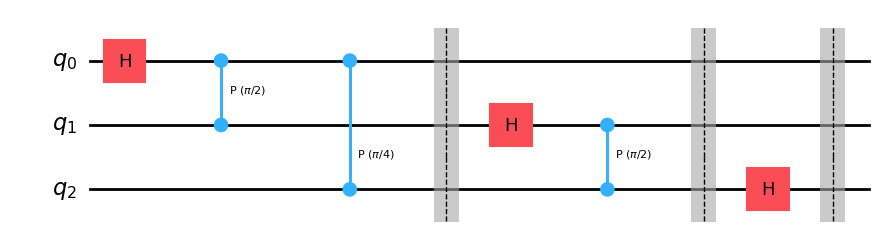

In [80]:
circ4 = QuantumCircuit(3)
qft_rotations(circ4,3)
circ4.draw(output = "mpl")

Now we add swaps to arrive at our desired output states

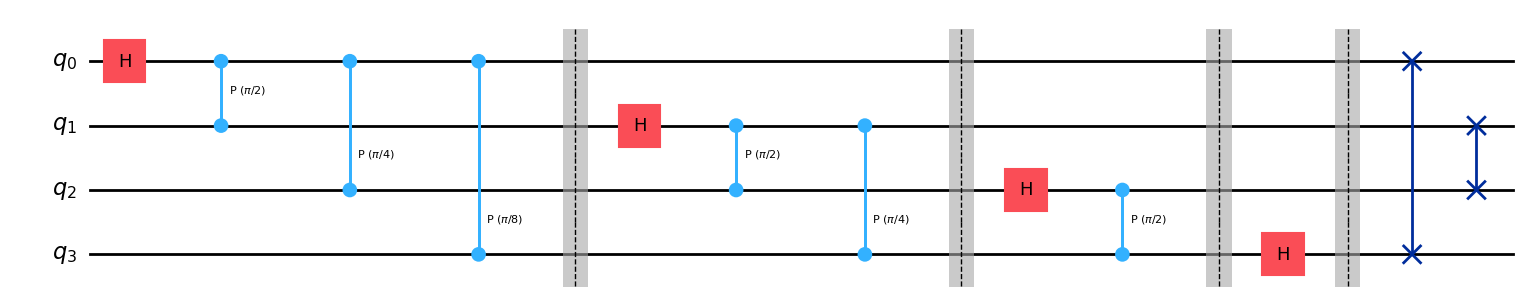

In [88]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit,n-qubit-1)
    return circuit

def qft(circuit, n):
    qft_rotations(circuit,n)
    swap_registers(circuit,n)
    return circuit

qc = QuantumCircuit(4)
qft(qc,4)
qc.draw(output="mpl")

Now let's test if this circuit works :) 

First, an example for 3

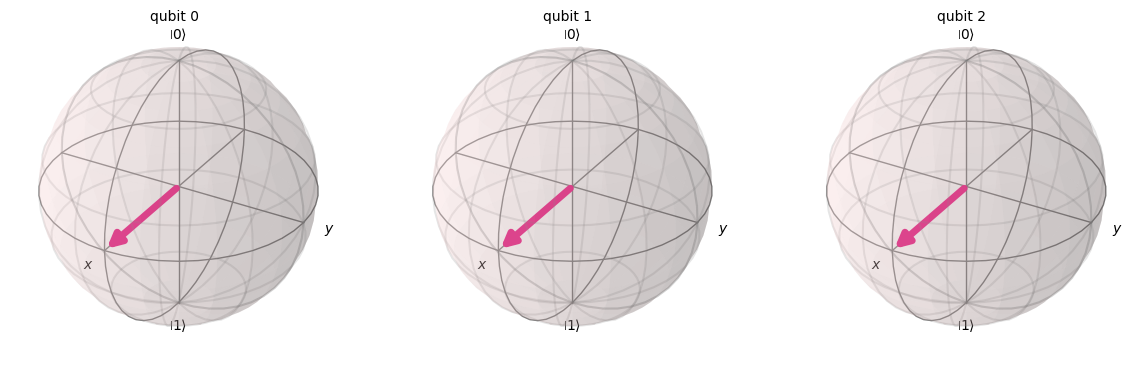

In [103]:
qc = QuantumCircuit(3)

# Use these to make different start states
#qc.x(0)
#qc.x(1)
#qc.x(2)
#qc.draw(output="mpl")

qft(qc,3)
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

# Extensions:

* How do we run this on real quantum hardware? can we do the exact same thing? or would there be a problem?
* How do you perform the reverse Fourier transform?
* If you want to learn more about QFT, phase estimation & Shor's algorithm , refer to Nielson & Chuang Chapter 5 :)

# Comment on Qiskit QFT

In qiskit, the first qubit rotates the slowest, so the circuit will look almost perfectly opposite to ours.

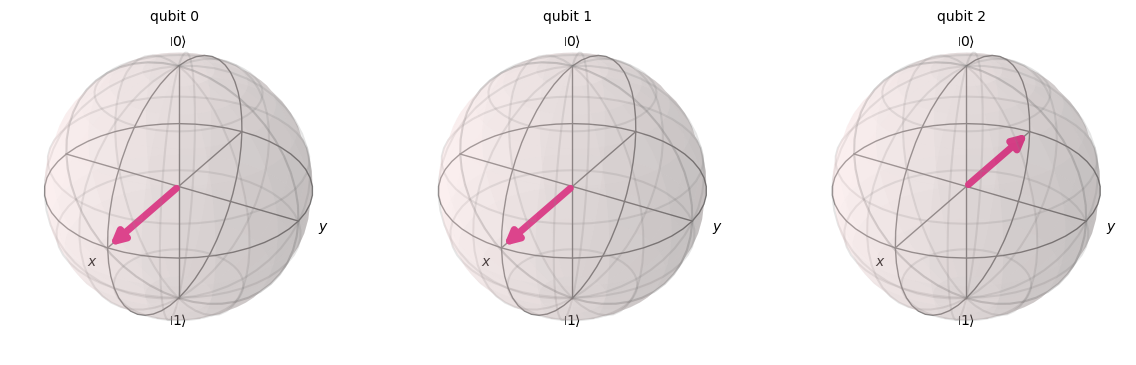

In [43]:
from qiskit.circuit.library import QFT

prepend = QuantumCircuit(3)
# Change the following line to experiment with different input states
prepend.x(1)
# Note different ordering of qubits and states!!!
prepend.barrier()
test = prepend & QFT(num_qubits=3, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=True)
test.draw(output='mpl')
statevector = Statevector(test2)
plot_bloch_multivector(statevector)
#backend = Aer.get_backend("statevector_simulator")
#statevector = execute(test, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

# Qiskit
![fourierbasis-counting](https://user-images.githubusercontent.com/293681/94955595-d17c2600-04b8-11eb-9977-439e00dff5bb.gif)
